## **Chapter 5: Pre-processing Data**
Ex3 : Consumer Complaint
Cho dữ liệu complaints.csv (Tham khảo chi tiết và download dữ liệu
tại: https://www.consumerfinance.gov/data-research/consumercomplaints/ (https://www.consumerfinance.gov/dataresearch/consumer-complaints/))
Yêu cầu:
1. Đọc dữ liệu => data.
2. Cho biết dữ liệu có bao nhiêu dòng, in scheme. Hiển thị 3 dòng dữ liệu đầu tiên.
3. Kiểm tra dữ liệu NaN, null
4. Kiểm tra dữ liệu trùng. Xóa dữ liệu trùng.
5. Kiểm tra lại dữ liệu null. Tính tỉ lệ %.
6. Tạo dữ liệu mới, trong đó không có các cột có dữ liệu thiếu trên 30%.
7. Xoá các dòng có "Date received" là null và/hoặc "Product" là null
8. Tạo cột "date_from_text" chứa dữ liệu yyyy-dd-mm từ "Date received" nếu có, nếu không sẽ
là ''. Lọc dữ liệu data_sub với yêu cầu "date_from_text" khác ''
9. Tạo cột "CCP" mới lấy dữ liệu từ cột "Consumer consent provided?". Với cột "CCP" hãy điền
"Consent not provided" thay cho null
10. Tạo cột "SV" mới lấy dữ liệu từ cột "Submitted via". Với cột "SV" hãy điền "Other" thay cho
null
11. Tạo cột "Sub-pr" mới lấy dữ liệu từ cột "Sub-product". Với cột "Sub-pr" hãy điền "I do not
know" thay cho null
12. Tạo cột State_new lấy giá trị từ cột State theo điều kiện sau: nếu có thông tin State thì lấy
thông tin, nếu không có thông tin thì điền "unknown"
13. Tạo cột Date_received với dữ liệu lấy từ cột "date_from_text", định dạng thời gian yyyy-mmdd.
14. Tạo cột mới chứa ngày trong tuần day_of_week (1: Monday, 7: Sunday) với dữ liệu lấy từ cột
'Date_received'
15. Tạo cột year, month chứa năm, tháng với dữ liệu lấy từ cột 'Date_received'
16. Vẽ biểu đồ thể hiện tần suất nhận complaint theo ngày trong tuần
17. Hãy cho biết 20 sản phẩm nhận complaint nhiều nhất. Đó là những sản phẩm nào? Biểu diễn
bằng đồ thị.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

spark-2.4.0-bin-hadoop2.7/
spark-2.4.0-bin-hadoop2.7/python/
spark-2.4.0-bin-hadoop2.7/python/setup.cfg
spark-2.4.0-bin-hadoop2.7/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/resultiterable.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/shell.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/heapq3.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/join.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/version.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/rdd.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/java_gateway.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/find_spark_home.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/_globals.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/worker.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/feature.py
spark-2.4.0-bin-hadoop2.7/python/pyspark

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung'

/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung


In [4]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import datediff
from pyspark.sql.functions import when

In [5]:
from pyspark import SparkContext
sc = SparkContext()

In [6]:
spark = SparkSession(sc)

In [7]:
# 1
data = spark.read.csv('data/complaints.csv', header=True, inferSchema=True)


In [8]:
#2. Cho biết dữ liệu có bao nhiêu dòng, in scheme. 
# Hiển thị 3 dòng dữ liệu đầu tiên.
data.count()

2083368

In [9]:
data.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub-issue: string (nullable = true)
 |-- Consumer complaint narrative: string (nullable = true)
 |-- Company public response: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)
 |-- Company response to consumer: string (nullable = true)
 |-- Timely response?: string (nullable = true)
 |-- Consumer disputed?: string (nullable = true)
 |-- Complaint ID: string (nullable = true)



In [10]:
for row in data.head(3):
    print(row)
    print("\n")


Row(Date received='2019-09-24', Product='Debt collection', Sub-product='I do not know', Issue='Attempts to collect debt not owed', Sub-issue='Debt is not yours', Consumer complaint narrative='transworld systems inc. ', Company public response=None, Company=None, State=None, ZIP code=None, Tags=None, Consumer consent provided?=None, Submitted via=None, Date sent to company=None, Company response to consumer=None, Timely response?=None, Consumer disputed?=None, Complaint ID=None)


Row(Date received='is trying to collect a debt that is not mine', Product=' not owed and is inaccurate."', Sub-product=None, Issue='TRANSWORLD SYSTEMS INC', Sub-issue='FL', Consumer complaint narrative='335XX', Company public response=None, Company='Consent provided', State='Web', ZIP code='2019-09-24', Tags='Closed with explanation', Consumer consent provided?='Yes', Submitted via='N/A', Date sent to company='3384392', Company response to consumer=None, Timely response?=None, Consumer disputed?=None, Complain

In [11]:
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import isnan, when, count, col

In [12]:
#3. Kiểm tra dữ liệu NaN, null
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,0
Issue,0
Sub-issue,0
Consumer complaint narrative,0
Company public response,0
Company,0
State,0
ZIP code,0


In [13]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas().T

,0
Date received,40
Product,209258
Sub-product,511176
Issue,325183
Sub-issue,931248
Consumer complaint narrative,1454171
Company public response,1412034
Company,573431
State,597994
ZIP code,673059


In [14]:
#4. Kiểm tra dữ liệu trùng. Xóa dữ liệu trùng.
num_rows = data.count()
num_dist_rows = data.distinct().count()
num_dist_rows

# Có dữ liệu trùng
dup_rows = num_rows - num_dist_rows
dup_rows


62759

In [15]:
# Xóa dữ liệu trùng
data = data.drop_duplicates()

In [16]:
data.distinct().count()


2020609

In [17]:
#5. Kiểm tra lại dữ liệu null. Tính tỉ lệ %. Xem xét cách xử lý dữ liệu null
null_data = data.select([count(when(col(c).isNull(), c)).alias(c) for c in
 data.columns]).toPandas().T

In [18]:
type(null_data)


pandas.core.frame.DataFrame

In [19]:
null_data

,0
Date received,39
Product,178373
Sub-product,472168
Issue,281416
Sub-issue,884470
Consumer complaint narrative,1405173
Company public response,1353196
Company,513337
State,537111
ZIP code,611785


In [20]:
null_data["percentage"] = (null_data[0]/num_dist_rows)*100
null_data

,0,percentage
Date received,39,0.001930
Product,178373,8.827685
Sub-product,472168,23.367608
Issue,281416,13.927286
Sub-issue,884470,43.772447
Consumer complaint narrative,1405173,69.542054
Company public response,1353196,66.969711
Company,513337,25.405064
State,537111,26.581639
ZIP code,611785,30.277258


In [21]:
#6. Tạo dữ liệu mới, trong đó không có các cột có dữ liệu thiếu trên 30%
data_sub = data.select(["Date received", "Product", 
                        "Sub-product", "Issue", 
                        "Company", "State", 
                        "Consumer consent provided?", 
                        "Submitted via"])

In [22]:
data_sub.show(2)

+--------------------+--------------------+----------------+--------------------+--------------------+-----+--------------------------+-------------+
|       Date received|             Product|     Sub-product|               Issue|             Company|State|Consumer consent provided?|Submitted via|
+--------------------+--------------------+----------------+--------------------+--------------------+-----+--------------------------+-------------+
|o While we do not...| we have been inf...|            null|                null|                null| null|                      null|         null|
|          2019-09-19|Credit reporting,...|Credit reporting|Improper use of y...|TRANSUNION INTERM...|   WI|          Consent provided|          Web|
+--------------------+--------------------+----------------+--------------------+--------------------+-----+--------------------------+-------------+
only showing top 2 rows



In [23]:
#7. Xoá các dòng có "Date received" là null và/hoặc "Product" là null
data_sub = data_sub.dropna(how="any", subset=["Date received", "Product"])

In [24]:
data_sub.select([count(when(col(c).isNull(), c)).alias(c) for c in data_sub.columns]).toPandas().T


,0
Date received,0
Product,0
Sub-product,332225
Issue,141159
Company,373348
State,397120
Consumer consent provided?,399331
Submitted via,381799


In [25]:
from pyspark.sql import functions as F 

In [26]:
#8. Tạo cột "date_from_text" chứa dữ liệu yyyy-dd-mm từ "Date received" nếu có
# nếu không sẽ là ''. 
# Lọc dữ liệu data_sub với yêu cầu "date_from_text" khác ''
data_sub = data_sub.withColumn("date_from_text", F.regexp_extract(data_sub["Date received"], r"(\d{4}-\d{1,2}-\d{1,2})", 0))



In [27]:
data_sub.select("date_from_text", "Date received").head(5)

[Row(date_from_text='', Date received='o While we do not know the details of the XXXX/CMHL compensation structure'),
 Row(date_from_text='2019-09-19', Date received='2019-09-19'),
 Row(date_from_text='', Date received='-XX/XX/XXXX letter where Certegy Payment Solutions '),
 Row(date_from_text='2019-04-04', Date received='2019-04-04'),
 Row(date_from_text='2019-02-18', Date received='2019-02-18')]

In [28]:
data_sub = data_sub.filter(data_sub["date_from_text"]!='')


In [29]:
data_sub.select("date_from_text", "Date received").head(10)


[Row(date_from_text='2019-09-19', Date received='2019-09-19'),
 Row(date_from_text='2019-04-04', Date received='2019-04-04'),
 Row(date_from_text='2019-02-18', Date received='2019-02-18'),
 Row(date_from_text='2019-05-25', Date received='2019-05-25'),
 Row(date_from_text='2019-03-28', Date received='2019-03-28'),
 Row(date_from_text='2018-12-28', Date received='2018-12-28'),
 Row(date_from_text='2019-08-08', Date received='2019-08-08'),
 Row(date_from_text='2019-04-04', Date received='2019-04-04'),
 Row(date_from_text='2019-04-22', Date received='2019-04-22'),
 Row(date_from_text='2019-03-27', Date received='2019-03-27')]

In [29]:
#9. Tạo cột "CCP" mới lấy dữ liệu từ cột "Consumer consent provided?" 
# Với cột "CCP" hãy điền "Consent not provided" thay cho null 
data_sub.select(["Consumer consent provided?"]).distinct().count()

In [30]:
data_sub = data_sub.withColumn("CCP", data_sub["Consumer consent provided?"])

In [31]:
data_sub = data_sub.fillna("Consent not provided", subset="CCP")

In [32]:
#10. Tạo cột "SV" mới lấy dữ liệu từ cột "Submitted via" 
# Với cột "SV" hãy điền "Other" thay cho null 
data_sub = data_sub.withColumn("SV", data_sub["Submitted via"])
data_sub = data_sub.fillna("Other", subset="SV")

In [34]:
#11. Tạo cột "Sub-pr" mới lấy dữ liệu từ cột "Sub-product" 
# Với cột "Sub-pr" hãy điền "I do not know" thay cho null 
data_sub = data_sub.withColumn("Sub-pr", data_sub["Sub-product"])
data_sub = data_sub.fillna("I do not know", subset="Sub-pr")

In [35]:
data_sub.select([count(when(col(c).isNull(), c)).alias(c) for c in data_sub.columns]).toPandas().T


,0
Date received,0
Product,0
Sub-product,234541
Issue,0
Company,147497
State,173009
Consumer consent provided?,174052
Submitted via,156052
date_from_text,0
CCP,0


In [36]:
#12. Tạo cột State_new lấy giá trị từ cột State theo điều kiện sau: 
# nếu có thông tin State thì lấy thông tin
# nếu không có thông tin thì điền "unknown"

data_sub = data_sub.withColumn('State_new', when(col('State').isNull(),'unknown').otherwise(col('State'))) 


In [37]:
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType


In [38]:
#13. Tạo cột Date_received với dữ liệu lấy từ cột "date_from_text", 
# định dạng thời gian yyyy-mm-dd . 
func = udf (lambda x: datetime.strptime(x, '%Y-%m-%d'), DateType())
data_sub = data_sub.withColumn('Date_received', func(col('date_from_text')))
data_sub.printSchema()


root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- date_from_text: string (nullable = true)
 |-- CCP: string (nullable = false)
 |-- SV: string (nullable = false)
 |-- Sub-pr: string (nullable = false)
 |-- State_new: string (nullable = true)
 |-- Date_received: date (nullable = true)



In [39]:
data_sub.select('Date_received').show(5)

+-------------+
|Date_received|
+-------------+
|   2019-09-19|
|   2019-04-04|
|   2019-02-18|
|   2019-05-25|
|   2019-03-28|
+-------------+
only showing top 5 rows



In [40]:
#14. Tạo cột mới chứa ngày trong tuần day_of_week (1: Monday, 7: Sunday) 
# với dữ liệu lấy từ cột 'Date_received'
data_sub = data_sub.withColumn('Day_of_Week', dayofweek('Date_received'))

In [41]:
from pyspark.sql.functions import year, month

In [42]:
#15. Tạo cột year, month chứa năm, tháng với dữ liệu lấy từ cột 'Date_received'
data_sub = data_sub.withColumn('year', year('Date_received')) \
 .withColumn('month', month('Date_received'))

In [43]:
data_sub.select('Date_received', 'Day_of_Week', 'month', 'year').show(5)

+-------------+-----------+-----+----+
|Date_received|Day_of_Week|month|year|
+-------------+-----------+-----+----+
|   2019-09-19|          5|    9|2019|
|   2019-04-04|          5|    4|2019|
|   2019-02-18|          2|    2|2019|
|   2019-05-25|          7|    5|2019|
|   2019-03-28|          5|    3|2019|
+-------------+-----------+-----+----+
only showing top 5 rows



In [44]:
data_sub.select([count(when(col(c).isNull(), c)).alias(c) for c in data_sub.columns]).toPandas().T

,0
Date received,0
Product,0
Sub-product,234541
Issue,0
Company,147497
State,173009
Consumer consent provided?,174052
Submitted via,156052
date_from_text,0
CCP,0


In [45]:
#16. Vẽ biểu đồ thể hiện tần suất nhận complaint theo ngày trong tuần
df = data_sub.select('Day_of_Week').toPandas()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff18fff9bd0>]],
      dtype=object)

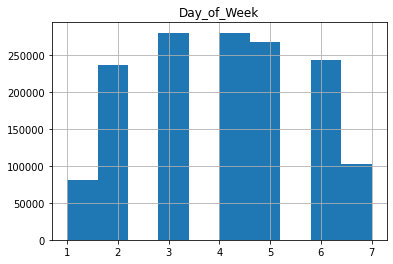

In [46]:
df.hist()

In [47]:
# Khách hàng complaint nhiều nhất vào thứ 4 và thứ 5

In [48]:
#17. Hãy cho biết 20 sản phẩm nhận complaint nhiều nhất. 
# Đó là những sản phẩm nào? Biểu diễn bằng đồ thị.
df_products = data_sub.groupby('product').count().orderBy('count', ascending=False).toPandas()
df_products.head(20)

,product,count
0,"Credit reporting, credit repair services, or o...",331635
1,Mortgage,295097
2,Debt collection,278961
3,Credit reporting,139825
4,Credit card,89175
5,Bank account or service,86193
6,Credit card or prepaid card,67849
7,Checking or savings account,57461
8,Student loan,56365
9,Consumer Loan,31592


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

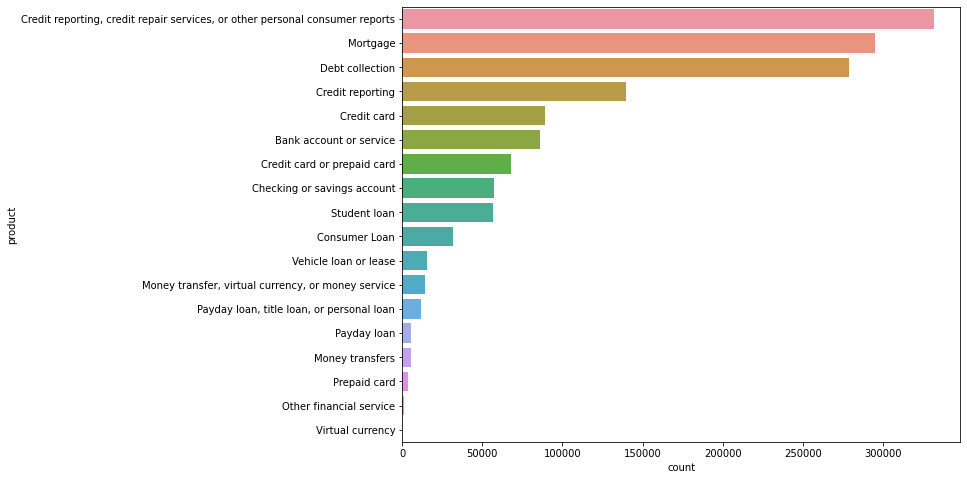

In [50]:
plt.figure(figsize=(10,8))
sns.barplot(data = df_products, x="count", y="product", )
plt.show()